# Preliminary setup and data exploration

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(100)
np.random.seed(100)

In [3]:
data = pd.read_csv('data/yahoo_reduced_arms.csv')
# Reshuffle data
data = data.sample(frac=1, random_state=100)

In [4]:
# Number of arms
n_arms = data['selected_arm'].max() + 1
n_arms

22

In [5]:
data.sample(n=5, random_state=100)

,1,2,3,4,5,6,7,8,9,10,...,130,131,132,133,134,135,136,selected_arm,reward,probability
28252,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,0,0.045455
22553,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0.045455
45324,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0.045455
2154,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,19,0,0.045455
37921,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0.045455


In [6]:
data.shape

(45791, 139)

There are 22 different arms. They seem to have been chosen uniformly randomly:

In [7]:
data['selected_arm'].describe()

count    45791.000000
mean        10.420825
std          6.357193
min          0.000000
25%          5.000000
50%         10.000000
75%         16.000000
max         21.000000
Name: selected_arm, dtype: float64

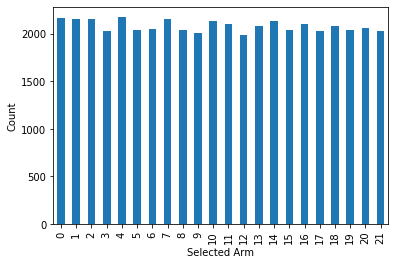

In [8]:
data['selected_arm'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Selected Arm')
plt.ylabel('Count')
plt.show()

The reward is a Bernoulli distribution:

In [9]:
data['reward'].describe()

count    45791.000000
mean         0.019109
std          0.136908
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: reward, dtype: float64

The reward expectancy depends on the arm chosen:

Text(0.5, 0, 'Selected Arm')

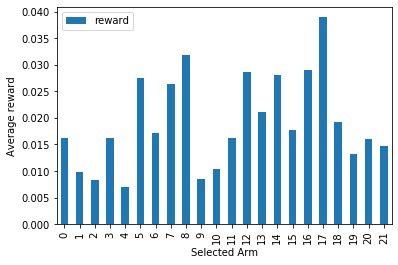

In [10]:
data.groupby('selected_arm').agg({'reward':'mean'}).plot(kind='bar')
plt.ylabel('Average reward')
plt.xlabel('Selected Arm')

All 136 features are bernoulli

# Creating Environments from the Data (Slot Machines)

This assumes the data has columns:
- `'selected_arm'` ranging from `0` to `(n_arms - 1)` corresponding to the selected arm
- `'reward'` which is the reward of the selected sample (row)

The experiments are sampled randomly from the data where the corresponding arm was chosen.

In [11]:
class Environment_From_Data():
    def __init__(self, data):
        """
        data: pd.DataFrame
            dataframe containing columns 'reward' and 'selected arm'
        """
        self.data = data
        # Save rewards grouped by arms to make the rest of computations go much faster
        self.data_groupby_arms = data.groupby('selected_arm')
    
    def get_reward(self, arm):
        # Chose randomly one index in the data with selected_arm = arm
        index = np.random.choice(self.data_groupby_arms.groups[arm])
        reward = data.loc[index, 'reward']
        return reward

In [12]:
environment = Environment_From_Data(data)

# Random argmax

The $\arg\max$ function is used very often in bandits algorithms. 

It is important to select a random arm in case of a tie.

In [13]:
def argmax(vec):
    return np.random.choice((vec == vec.max()).nonzero()[0])

# Defining a base Agent other will be based upon

These are the basic properties of a multi-armed bandit.

In [14]:
class Agent():
    def __init__(self, n_arms):
        """
        n_arms: int
            Number of arms
        """
        self.n_arms = n_arms
        self.tries = np.zeros(n_arms)
        self.successes = np.zeros(n_arms)
        
    @property
    def _total_tries(self): 
        return self.tries.sum()
    
    def add_observation(self, arm, reward):
        """
        arm: int
            Chosen arm of the observation
        reward: float
            Reward of the observation
        """
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        """Placeholder way of selecting an arm."""
        arm = self._total_tries % self.n_arms
        return arm

# Implementing a simple Explore First then Greedy strategy

We explore for `learning_stop` steps then exploit the reward that gave the most expected reward so far.

In [15]:
class GreedyExploreFirst(Agent):
    def __init__(self, n_arms, learning_stop):
        """
        n_arms: int
            Number of arms
        learning_stop: int
            Time step until we decide to stop chosing arms randomly
        """
        super().__init__(n_arms)
        self.learning_stop = learning_stop
    
    def select_arm(self):
        # if learning hasn't stopped yet, chose random arm
        if self._total_tries < self.learning_stop:
            arm = self._total_tries % self.n_arms # can also replace with arm = random.randint(0, self.n_arms - 1)
        # else chose arm with most success rate
        else:
            success_rate = self.successes / self.tries
            arm = argmax(success_rate)
        arm = int(arm)
        return arm

In [16]:
agent = GreedyExploreFirst(n_arms=n_arms, learning_stop=n_arms*200) #Setting 200 tries per arm

In [17]:
total_reward = []
T = 10000 # Total testing time
arms= []
for row in range(int(T)):
    arm = agent.select_arm()
    arms.append(arm)
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())

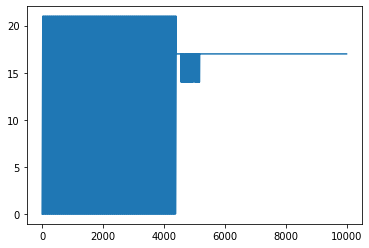

In [18]:
plt.plot(arms)

In [19]:
agent.select_arm()

17

Text(0, 0.5, 'Total Reward')

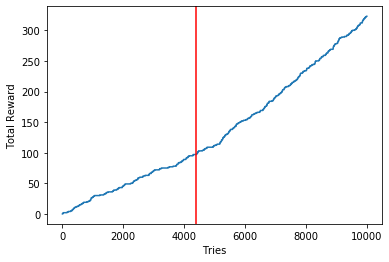

In [20]:
plt.plot(total_reward)
plt.axvline(agent.learning_stop, c='r')
plt.xlabel('Tries')
plt.ylabel('Total Reward')

In [21]:
total_reward[-1]

323.0

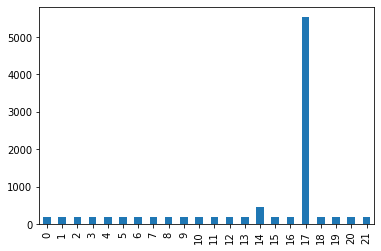

In [22]:
pd.Series(agent.tries).plot.bar()

# Implementing an Epsilon Greedy Strategy

At each step, we throw an $\epsilon$-weighted coin toss do decide wether to explore or exploit.

In [23]:
from scipy.stats import bernoulli

class EpsilonGreedy(Agent):

    @property
    def _epsilon(self):
        # value taken from https://arxiv.org/pdf/1904.07272.pdf theorem 1.6
        epsilon = (self.n_arms * np.log(self._total_tries + 1) / self._total_tries) ** (1/3)
        epsilon = min(epsilon, 1)
        return epsilon
    
    def select_arm(self):
        # if epsilon-weighted coin toss is true, explore
        
        if self._total_tries < n_arms:
            arm = self._total_tries
        else:
            epsilon = self._epsilon
            if bernoulli(epsilon).rvs():
                arm = random.randint(0, self.n_arms - 1)
            # else exploit (chose arm with most success rate)
            else:
                success_rate = self.successes / (self.tries + 1e-6)
                arm = argmax(success_rate)
        arm = int(arm)
        return arm

In [24]:
agent = EpsilonGreedy(n_arms=n_arms)

In [25]:
total_reward = []
epsilon_history = []
for row in range(int(T)):
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    epsilon_history.append(agent._epsilon)
    total_reward.append(agent.successes.sum())

In [26]:
agent.select_arm()

17

Text(0, 0.5, 'Total Reward')

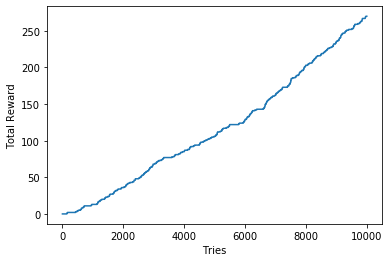

In [27]:
plt.plot(total_reward)
plt.xlabel('Tries')
plt.ylabel('Total Reward')

Text(0, 0.5, 'Epsilon')

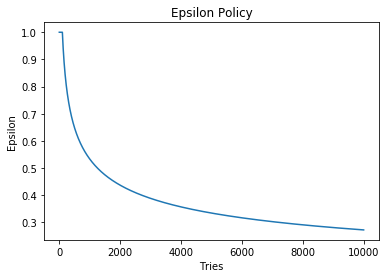

In [28]:
plt.plot(epsilon_history)
plt.title('Epsilon Policy')
plt.xlabel('Tries')
plt.ylabel('Epsilon')

In [29]:
total_reward[-1]

270.0

In [30]:
agent._epsilon

0.27262626388255085

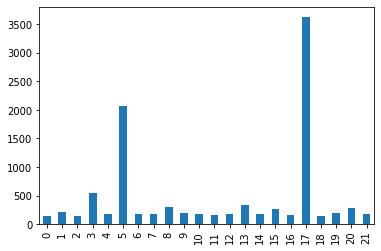

In [31]:
pd.Series(agent.tries).plot.bar()

# UCB1

This uses the concept of 'optimism under uncertainty'. We assume the expected reward of each arm is the upper confidence bound (UCB) of the arm so far.

The confidence radius is calculated using Hoeffding’s Inequality.

In [32]:
class UCB1(Agent):
        
    @property
    def _confidence_radius(self):
        radius = np.sqrt(2 * np.log(self._total_tries) / self.tries)
        return radius
    
    @property
    def _ucb(self):
        success_rate = self.successes / self.tries
        return success_rate + self._confidence_radius
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else: 
            ucb = self._ucb
            arm = argmax(ucb)
        arm = int(arm)
        return arm

In [33]:
agent = UCB1(n_arms=n_arms)

In [34]:
total_reward = []
T = 10000 # Total testing time
for row in range(int(T)):
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())

Text(0, 0.5, 'Total Reward')

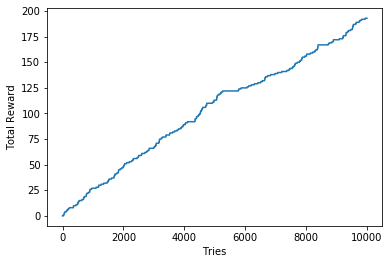

In [35]:
plt.plot(total_reward)
plt.xlabel('Tries')
plt.ylabel('Total Reward')

In [36]:
total_reward[-1]

193.0

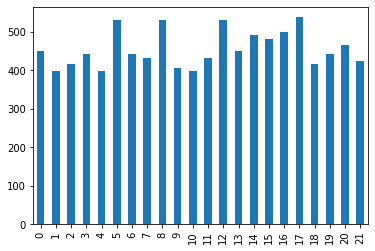

In [37]:
pd.Series(agent.tries).plot.bar()

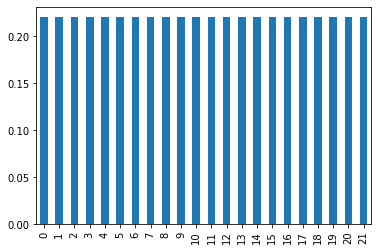

In [38]:
pd.Series(agent._ucb).plot.bar()

In [39]:
agent._confidence_radius

array([0.2025488 , 0.2154059 , 0.21068266, 0.20437772, 0.2154059 ,
       0.18642962, 0.20437772, 0.20649568, 0.18642962, 0.21300501,
       0.2154059 , 0.20649568, 0.18642962, 0.2025488 , 0.19388973,
       0.19549215, 0.19232607, 0.18503833, 0.21068266, 0.20437772,
       0.19881991, 0.20843465])

In [40]:
agent._ucb

array([0.22036617, 0.22044368, 0.22032121, 0.22025073, 0.22044368,
       0.22039188, 0.22025073, 0.22038457, 0.22039188, 0.22039417,
       0.22044368, 0.22038457, 0.22039188, 0.22036617, 0.22042034,
       0.22038841, 0.22043852, 0.22035432, 0.22032121, 0.22025073,
       0.22027914, 0.2202271 ])

# Bayesian UCB

Instead of assessing the UCB roughly with Hoeffding’s Inequality, we use our knowledge of the Bernoulli distribution and it's conjugate prior, the Beta distribution, to assess the upper confindence bound

In [41]:
from scipy.stats import beta

class BayesUCB(Agent):
    def __init__(self, n_arms, c=2):
        """
        n_arms: int
            Number of arms
        c: float
            Amount of standard deviations considered for the UCB
        """
        super().__init__(n_arms)
        self.c = c # Amount of standard deviations considered for ucb
        self._params_a = np.ones(n_arms) # Params a of Beta
        self._params_b = np.ones(n_arms) # Params b of Beta
  
    def add_observation(self, arm, reward):
        """
        arm: int
            Arm chosen in the observation
        reward: bool
            Reward obtained in the observation
        """
        super().add_observation(arm,reward)
        self._params_a[arm] += reward
        self._params_b[arm] += 1 - reward
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else: 
            ucb = self._params_a / (self._params_a + self._params_b) # Mean
            ucb += self.c * beta.std(self._params_a, self._params_b) # Confidence Radius
            arm = argmax(ucb)
        arm = int(arm)
        return arm

In [42]:
agent = BayesUCB(n_arms=n_arms)

In [43]:
total_reward = []
T = 10000 # Total testing time
for row in range(int(T)):
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())

Text(0, 0.5, 'Total Reward')

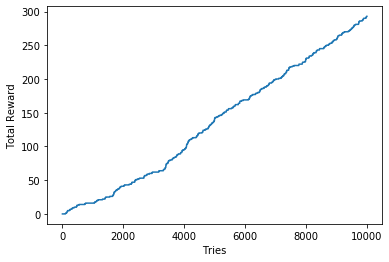

In [44]:
plt.plot(total_reward)
plt.xlabel('Tries')
plt.ylabel('Total Reward')

In [45]:
total_reward[-1]

293.0

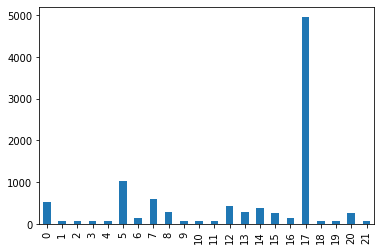

In [46]:
pd.Series(agent.tries).plot.bar()

# Thompson Sampling

Every arm is supposed to be a Beta distribution with parameters a = success, b = failures.

At each step we sample from the Beta distributions of all arms and chose the arm with the largest sample.

In [47]:
from scipy.stats import beta

class ThompsonSampling(Agent):
    def __init__(self, n_arms, c=2):
        """
        n_arms: int
            Number of arms
        c: float
            Amount of standard deviations considered for the UCB
        """
        super().__init__(n_arms)
        self.c = c # Amount of standard deviations considered for ucb
        self._params_a = np.ones(n_arms) # Params a of Beta
        self._params_b = np.ones(n_arms) # Params b of Beta
  
    def add_observation(self, arm, reward):
        """
        arm: int
            Arm chosen in the observation
        reward: bool
            Reward obtained in the observation
        """
        super().add_observation(arm,reward)
        self._params_a[arm] += reward
        self._params_b[arm] += 1 - reward
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else:
            # Sample from the beta distribution and chose the argmax
            vec = beta(self._params_a, self._params_b).rvs()
            arm = np.random.choice((vec == vec.max()).nonzero()[0])
        arm = int(arm)
        return arm

In [48]:
agent = ThompsonSampling(n_arms=n_arms)

In [49]:
total_reward = []
T = 10000 # Total testing time
for row in range(int(T)):
    arm = agent.select_arm()
    agent.add_observation(arm, environment.get_reward(arm))
    total_reward.append(agent.successes.sum())

Text(0, 0.5, 'Total Reward')

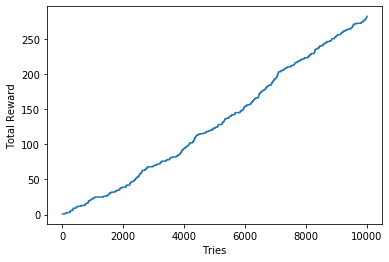

In [50]:
plt.plot(total_reward)
plt.xlabel('Tries')
plt.ylabel('Total Reward')

In [51]:
total_reward[-1]

282.0

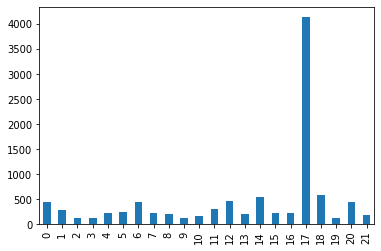

In [52]:
pd.Series(agent.tries).plot.bar()